# Machine Learning for Cybersecurity - Lab 02

**Adversarial Attacks on Deep Neural Networks** </br> </br>
**Name:** Sagar Patel </br>
**NETID:** SP5894

---

## Part 0: Import packages and process data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from numpy import newaxis

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape)
print(x_test.shape)
print(type(x_train))

(60000, 28, 28)
(10000, 28, 28)
<class 'numpy.ndarray'>


We will visualize the data

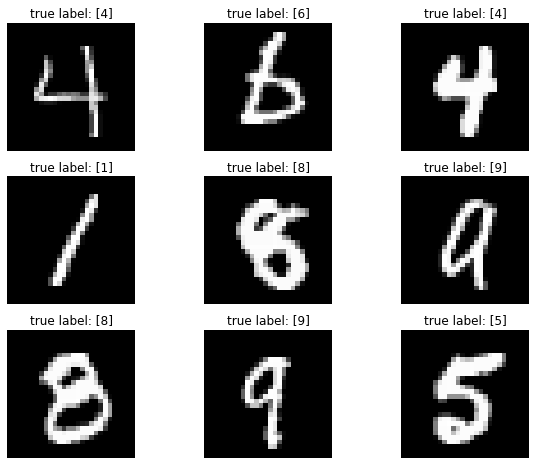

In [4]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_train.shape[0], size=1)
  img, label = (x_train[index], y_train[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Baseline DNN model
The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations.

In [5]:
DNN = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)                                 
])

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [7]:
DNN.compile(optimizer='adam', loss=loss_fn,metrics=['accuracy'])

In [8]:
DNN.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2161 - accuracy: 0.9371
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0890 - accuracy: 0.9732
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0594 - accuracy: 0.9812
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0417 - accuracy: 0.9868
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0311 - accuracy: 0.9901


In [9]:
res = DNN.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0735 - accuracy: 0.9779 - 640ms/epoch - 2ms/step


In [10]:
def correct_classified(model, X, Y):
  correct_classified_img = []
  correct_classified_img_label = []
  count = 0
  
  for i, img in enumerate(X):
    img = img[newaxis, ...]
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      count+=1
      correct_classified_img.append(tf.convert_to_tensor(img, dtype=tf.float32))
      correct_classified_img_label.append(tf.convert_to_tensor(Y[i]))
  return count, correct_classified_img, correct_classified_img_label

## Part 01: FGSM based untargeted attacks

Aiming to fool the neural network and output a label different than the original one. Non-target FGS method is expresed as $-$
$$
x'\leftarrow clip(x+\epsilon sign(\triangledown \mathcal{l}_{F,y^*}(x)))
$$

Here, $\epsilon$ is a small constraint scalar, $\mathcal{l}$ is the loss function

In [11]:
def generate_perturb_untarget_img(model, X, Y, epsilon0):
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  x_perturb = []
    
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(X)
    pred = model(X)
    loss = loss_fn(Y, pred)
  grad = tape.gradient(loss, X)
  grad_sign = tf.sign(grad)
  x_perturb.append(tf.clip_by_value((X + epsilon0 * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [12]:
def generate_perturb_untarget_correct_img(model, X, Y, epsilon0):
  x_perturb = []
  for i, img in enumerate(X):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
         
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(img)
      pred = model(img)
      loss = loss_fn(Y[i], pred)
    grad = tape.gradient(loss, img)
    grad_sign = tf.sign(grad)
    x_perturb.append(tf.clip_by_value((img + epsilon0 * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [13]:
def cal_Perturb_classify_acc(model, perturbImg, Y):
  pred = model.predict(perturbImg)
  pred = tf.nn.softmax(pred)
  pred = tf.math.argmax(pred, axis=1).numpy()
  res = model.evaluate(perturbImg,  Y, verbose=2)
  return res, pred

In [14]:
def cal_Perturb_correct_classify_acc(model, perturbImg, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(perturbImg):
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      pred_label.append(pred)
      count+=1
  return count/len(Y), pred_label

In [15]:
epsilons = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
acc_untarget = []
success_untarget_attack_rate = []
numOfCorrectClassified, correct_classified_img, correct_classified_img_label = correct_classified(DNN, x_test, y_test)
for eps in epsilons:
  x_perturb = generate_perturb_untarget_img(DNN, x_test, y_test, eps)
  acc, y_pred = cal_Perturb_classify_acc(DNN, x_perturb, y_test)
  acc_untarget.append(acc[1])
  
  x_perturb_correct_classified = generate_perturb_untarget_correct_img(DNN, correct_classified_img, correct_classified_img_label, eps)
  acc_perturb_classified, y_correct_pred = cal_Perturb_correct_classify_acc(DNN, x_perturb_correct_classified, correct_classified_img_label)
  success_untarget_attack_rate.append(1-acc_perturb_classified)

313/313 - 1s - loss: 0.0931 - accuracy: 0.9712 - 702ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2236 - accuracy: 0.9341 - 630ms/epoch - 2ms/step
313/313 - 1s - loss: 0.6091 - accuracy: 0.8207 - 593ms/epoch - 2ms/step
313/313 - 1s - loss: 2.7031 - accuracy: 0.3581 - 606ms/epoch - 2ms/step
313/313 - 1s - loss: 5.8300 - accuracy: 0.1253 - 660ms/epoch - 2ms/step
313/313 - 1s - loss: 8.7994 - accuracy: 0.0628 - 611ms/epoch - 2ms/step
313/313 - 1s - loss: 11.5274 - accuracy: 0.0319 - 604ms/epoch - 2ms/step


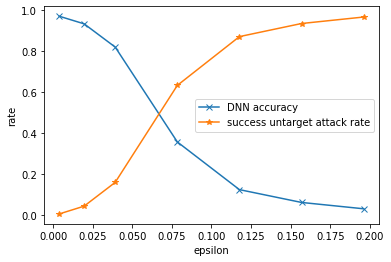

In [16]:
plt.plot(epsilons,acc_untarget,marker='x')
plt.plot(epsilons,success_untarget_attack_rate,marker='*')
plt.xlabel('epsilon')
plt.ylabel('rate')
plt.legend(['DNN accuracy','success untarget attack rate'])

In [17]:
print("Untarget attack")
for i, eps in enumerate(epsilons):
  print("epsilon is:{}, success attack rate is: {}".format(eps, success_untarget_attack_rate[i]))

Untarget attack
epsilon is:0.00392156862745098, success attack rate is: 0.006851416300235225
epsilon is:0.0196078431372549, success attack rate is: 0.04478985581347783
epsilon is:0.0392156862745098, success attack rate is: 0.16075263319357802
epsilon is:0.0784313725490196, success attack rate is: 0.6338071377441457
epsilon is:0.11764705882352941, success attack rate is: 0.8718682891911238
epsilon is:0.1568627450980392, success attack rate is: 0.9357807546783925
epsilon is:0.19607843137254902, success attack rate is: 0.9673790776152981


## Part 02: FGSM based targeted attacks

Intentionally misleading the network to output a specific label designed by the attacker. The formula is given by $-$
$$
x'\leftarrow clip(x-\epsilon sign(\triangledown \mathcal{l}_{F,y'}(x)))
$$

Here, $\epsilon$ is a small constraint scalar, $\mathcal{l}$ is the loss function

In [18]:
def generate_perturb_target_img(model, X, Y, epsilon):
  y_test_modify = []
  for i in Y:
    y_test_modify.append((i+1)%10)
  x_perturb = []   
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    pred = model(x_tensor)
    loss = loss_fn(y_test_modify, pred)
  grad = tape.gradient(loss, x_tensor)
  grad_sign = tf.sign(grad)
  x_perturb.append(tf.clip_by_value((x_tensor - epsilon * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [19]:
def generate_perturb_target_correct_img(model, X, Y, epsilon0):
  y_test_modify = []
  for i in Y:
    y_test_modify.append((i+1)%10)
    
  x_perturb = []
  for i, img in enumerate(X):   
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(x_tensor)
      pred = model(x_tensor)
      loss = loss_fn(y_test_modify[i], pred)
    grad = tape.gradient(loss, x_tensor)
    grad_sign = tf.sign(grad)
    x_perturb.append(tf.clip_by_value((x_tensor - epsilon0 * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [20]:
def cal_Perturb_correct_classify_tar_acc(model, perturbImg, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(perturbImg):
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    pred_label.append(pred)
    
    if pred[0] == (Y[i]+1).numpy(): 
      pred_label.append(pred)
      count+=1
  return count/len(Y), pred_label

In [21]:
acc_target = []
success_target_attack_rate = []

epsilons = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
numOfCorrectClassifiedTar, correct_classified_tar_img, correct_classified_tar_img_label = correct_classified(DNN, x_test, y_test)
for eps in epsilons:
  x_perturb_tar = generate_perturb_target_img(DNN, x_test, y_test, eps)
  acc_tar, y_pred_tar = cal_Perturb_classify_acc(DNN, x_perturb_tar, y_test)
  acc_target.append(acc_tar[1])
  
  x_perturb_correct_tar_classified = generate_perturb_target_correct_img(DNN, correct_classified_tar_img, correct_classified_tar_img_label, eps)
  acc_perturb_tar_classified, y_correct_tar_pred = cal_Perturb_correct_classify_tar_acc(DNN, x_perturb_correct_tar_classified, correct_classified_tar_img_label)
  success_target_attack_rate.append(acc_perturb_tar_classified)

313/313 - 1s - loss: 0.0733 - accuracy: 0.9776 - 621ms/epoch - 2ms/step
313/313 - 1s - loss: 0.0914 - accuracy: 0.9706 - 597ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2005 - accuracy: 0.9334 - 607ms/epoch - 2ms/step
313/313 - 1s - loss: 1.3148 - accuracy: 0.6078 - 624ms/epoch - 2ms/step
313/313 - 1s - loss: 3.9100 - accuracy: 0.2662 - 606ms/epoch - 2ms/step
313/313 - 1s - loss: 6.9421 - accuracy: 0.0918 - 616ms/epoch - 2ms/step
313/313 - 1s - loss: 9.8977 - accuracy: 0.0321 - 647ms/epoch - 2ms/step


Text(0.5, 1.0, 'Target Attack')

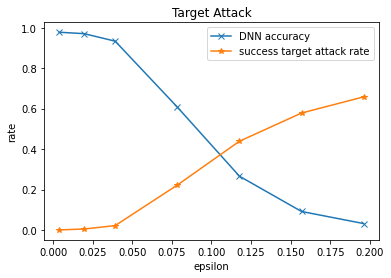

In [22]:
plt.plot(epsilons,acc_target,marker='x')
plt.plot(epsilons,success_target_attack_rate,marker='*')
plt.xlabel('epsilon')
plt.ylabel('rate')
plt.legend(['DNN accuracy','success target attack rate'])
plt.title("Target Attack")

In [23]:
print("Target Attack")
for i, eps in enumerate(epsilons):
  print("epsilon: {}, success attack rate: {}".format(eps, success_target_attack_rate[i]))

Target Attack
epsilon: 0.00392156862745098, success attack rate: 0.0007158196134574087
epsilon: 0.0196078431372549, success attack rate: 0.005215257183761121
epsilon: 0.0392156862745098, success attack rate: 0.02208814807240004
epsilon: 0.0784313725490196, success attack rate: 0.22241537989569485
epsilon: 0.11764705882352941, success attack rate: 0.4388996829941712
epsilon: 0.1568627450980392, success attack rate: 0.5783822476735863
epsilon: 0.19607843137254902, success attack rate: 0.6582472645464772


## Part 03: Adversarial Retraining against Untargeted FGSM Attacks

For this part, we are assuming $\epsilon$ = 10/255. </br>
To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.

In [24]:
epsilon = 10/255
x_perturb_retrain = generate_perturb_untarget_img(DNN, x_train, y_train, epsilon)
y_retrain = np.hstack((y_train, y_train))
x_retrain = []
for re in x_perturb_retrain:
  x_retrain = np.vstack((x_train, re))

In [25]:
print(len(x_retrain))

120000


In [26]:
DNN_retrain = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)                                 
])

In [27]:
DNN_retrain.compile(optimizer='adam', loss=loss_fn,metrics=['accuracy'])

In [28]:
DNN_retrain.fit(x_retrain, y_retrain, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 13s 3ms/step - loss: 0.1348 - accuracy: 0.9607
Epoch 2/5
3750/3750 [==============================] - 13s 3ms/step - loss: 0.0447 - accuracy: 0.9860
Epoch 3/5
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0283 - accuracy: 0.9906
Epoch 4/5
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0198 - accuracy: 0.9935
Epoch 5/5
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0153 - accuracy: 0.9947


In [29]:
res_retrain = DNN_retrain.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0849 - accuracy: 0.9791 - 614ms/epoch - 2ms/step


Get perturb image from DNN_retrain

In [30]:
numOfCorrectClassified, correct_classified_img, correct_classified_img_label = correct_classified(DNN, x_test, y_test)
x_perturb = generate_perturb_untarget_img(DNN_retrain, x_test, y_test, epsilon)
acc_retrain, y_pred_retrain = cal_Perturb_classify_acc(DNN_retrain, x_perturb, y_test)

x_perturb_correct_classified = generate_perturb_untarget_correct_img(DNN_retrain, correct_classified_img, correct_classified_img_label, epsilon)
acc_perturb_classified, y_correct_pred = cal_Perturb_correct_classify_acc(DNN_retrain, x_perturb_correct_classified, correct_classified_img_label)

313/313 - 1s - loss: 7.7462 - accuracy: 0.2300 - 714ms/epoch - 2ms/step


In [31]:
print("The success attack rate is: {}".format(1-acc_perturb_classified))

The success attack rate is: 0.7648021270068515


Get perturb images from baseline DNN

In [32]:
x_perturb_DNN = generate_perturb_untarget_img(DNN, x_test, y_test, epsilon)
acc_retrain1, y_pred_retrain1 = cal_Perturb_classify_acc(DNN_retrain, x_perturb_DNN, y_test)

x_perturb_correct_classified_DNN = generate_perturb_untarget_correct_img(DNN, correct_classified_img, correct_classified_img_label, epsilon)
acc_perturb_classified1, y_correct_pred1 = cal_Perturb_correct_classify_acc(DNN_retrain, x_perturb_correct_classified_DNN, correct_classified_img_label)

313/313 - 1s - loss: 0.0187 - accuracy: 0.9954 - 619ms/epoch - 2ms/step


In [33]:
print("The success attack rate is: {}".format(1-acc_perturb_classified1))

The success attack rate is: 0.0009203395030166206


We can see that the success attack rate is high if we use the images that are generated from DNN_retrain. Therefore, making it less robust. However, if the images are generated from the baseline DNN then DNN_retrain works well.

## Part 04: Challenge

We will be implementing IFGS here which stands for Iterative Fast Gradient Sign methods. IFGS will perturb each pixel with a small amount for multiple times. IFGS methods are capable of generating adversarial inputs with smaller distortion when compared to basic FGS methods. For non-targeted attacks, the formula will be $-$
$$
x_0'=x,x_{N+1}'\leftarrow clip_{\epsilon}(x_N'+\alpha sign(\triangledown \mathcal{l}_{F,y^*}(x)))
$$



In [34]:
fashionMnist = tf.keras.datasets.fashion_mnist

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashionMnist.load_data()
x_train_fashion, x_test_fashion = x_train_fashion / 255.0, x_test_fashion / 255.0

4431872/4422102 [==============================] - 0s 0us/step


In [35]:
print(x_train_fashion.shape)
print(x_test_fashion.shape)

(60000, 28, 28)
(10000, 28, 28)


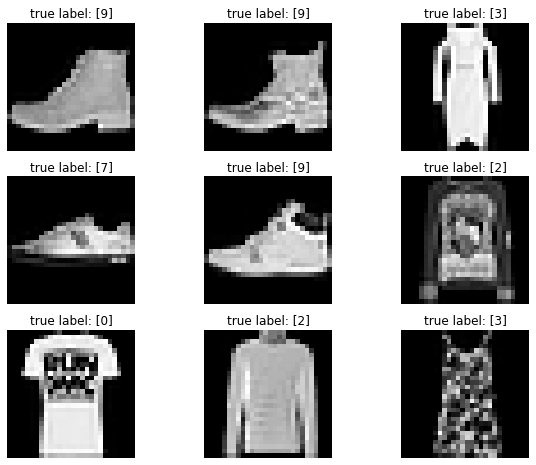

In [36]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_train_fashion.shape[0], size=1)
  img, label = (x_train_fashion[index], y_train_fashion[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [37]:
DNN_fashion = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)                                 
])

In [38]:
DNN_fashion.compile(optimizer='adam', loss=loss_fn,metrics=['accuracy'])
DNN_fashion.fit(x_train_fashion, y_train_fashion, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4833 - accuracy: 0.8288
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3654 - accuracy: 0.8665
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3269 - accuracy: 0.8806
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3026 - accuracy: 0.8876
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2848 - accuracy: 0.8941


In [39]:
res = DNN_fashion.evaluate(x_test_fashion,  y_test_fashion, verbose=2)

313/313 - 1s - loss: 0.3441 - accuracy: 0.8780 - 614ms/epoch - 2ms/step


In [40]:
def generate_perturb_untarget_im_iter(iteration, model, X, Y, epislon):
  x_perturb = [] 
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  for i in range(iteration):
    
    with tf.GradientTape() as tape:
      tape.watch(x_tensor)
      pred = model(x_tensor)
      loss = loss_fn(Y, pred)
    grad = tape.gradient(loss, x_tensor)
    grad_sign = tf.sign(grad)
    x_tensor = tf.clip_by_value((x_tensor + epislon * grad_sign), clip_value_min = 0, clip_value_max = 1)
  x_perturb.append(x_tensor)
  return x_perturb

In [41]:
def calRMSE(adv_img, ori_img):
  RMSE = []
  for i, img in enumerate(adv_img):
    rmse = np.sqrt(np.sum((img-ori_img[i])**2)/(28*28))
    RMSE.append(rmse)
    
  return np.sum(RMSE)/len(RMSE)

In [42]:
x_perturb_fashion = generate_perturb_untarget_im_iter(5, DNN_fashion, x_test_fashion, y_test_fashion, 1/255)

In [43]:
RMSE = calRMSE(x_perturb_fashion[0], x_test_fashion)

In [44]:
print("The RMSE of original images and perturb images is: {}".format(RMSE))

The RMSE of original images and perturb images is: 0.01668652811431063


The RMSE is less than 5/255 = 0.0196. So, we will do 5 iterations and when epsilon = 1/255.

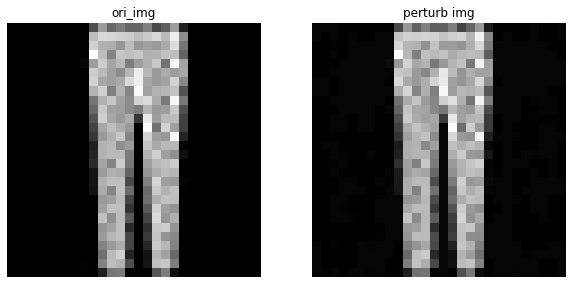

In [45]:
figure = plt.figure(figsize=(10,8))
index = np.random.randint(x_test_fashion.shape[0], size=1)
img1, label1 = (x_test_fashion[index], y_test_fashion[index])
figure.add_subplot(1, 2, 1)
plt.title("ori_img")
plt.axis("off")
plt.imshow(img1.squeeze(), cmap="gray")
img2, label2 = (np.array(x_perturb_fashion[0][index[0]]), y_test_fashion[index])
figure.add_subplot(1, 2, 2)
plt.title("perturb img")
plt.axis("off")
plt.imshow(img2.squeeze(), cmap="gray")
plt.show()